In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm

import igraph as ig
import networkx as nx

#from matplotlib import rc, rcParams
from matplotlib.colors import LogNorm

from scipy.integrate import odeint
from HTC_utils import *

from scipy.stats import truncnorm

In [2]:
folder = 'data_r1_001_r2_1/'

In [3]:
# Define parameters
r1 = 0.001
r2 = 0.1

Tminus = r1 * r2 / (r1 + r2 + r1*r2)
Tplus = r2 / (2*r2 +1)

xplus = Tplus
yplus = Tplus / r2

xminus = Tminus
yminus = Tminus / r2

print(Tminus)
print(Tplus)

0.0009891196834817012
0.08333333333333334


In [4]:
# Load matrices
W = np.loadtxt('connectome.txt')
Wrand = np.load('randomized/333749_8.txt.npy')
Wbin = np.loadtxt('connectome.txt')
Wbin = (Wbin>0).astype(int)

# Normalize
W = normalize(W)
Wbin = normalize(Wbin)
Wrand = normalize(Wrand)

# Varying connectivity

In [264]:
ps = [0.01, 0.05, 0.1, 0.2, 0.4, 0.6,]
#ps = [0.1, 0.3, 0.6]
Ts = [0.5*Tminus, Tminus + 0.5*(Tplus-Tminus), 2.*Tplus]
#Ts = [0.5*Tminus, Tminus + 0.3*(Tplus-Tminus), Tminus + 0.5*(Tplus-Tminus), Tminus + 0.7*(Tplus-Tminus), 2.*Tplus]
titles = [r'$T<T_-$', r'$T_-<T<T_+$', r'$T>T_+$']

dt = 0.01
steps = int(5e3)
N = int(1e3)

res = []

for p in ps:
    tmp_res = []
    
    # Generate graphs
    print('[*] Generating topology for p={:.2f}'.format(p))
    top = ig.Graph.Erdos_Renyi(n=N, p=p).get_adjacency_sparse().toarray()
    # Homeostatic normalization
    top = normalize(top)
    
    for T in Ts:
        print('[-] T='+str(T))
        # Run model
        x, y = run_htc_single(None, xplus, yplus, T, r1, r2, dt, steps, N=N, runs=30)
        tmp_res.append(x)
        name = 'traj_N_{}_dt_{}_p_{}_T_{}.npy'.format(N,np.round(dt,3),np.round(p,2),np.round(np.log10(T),2))
        np.save(folder+name, x)
    res.append(tmp_res)

[*] Generating topology for p=0.01
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.05
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.10
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.20
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.40
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.60
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669


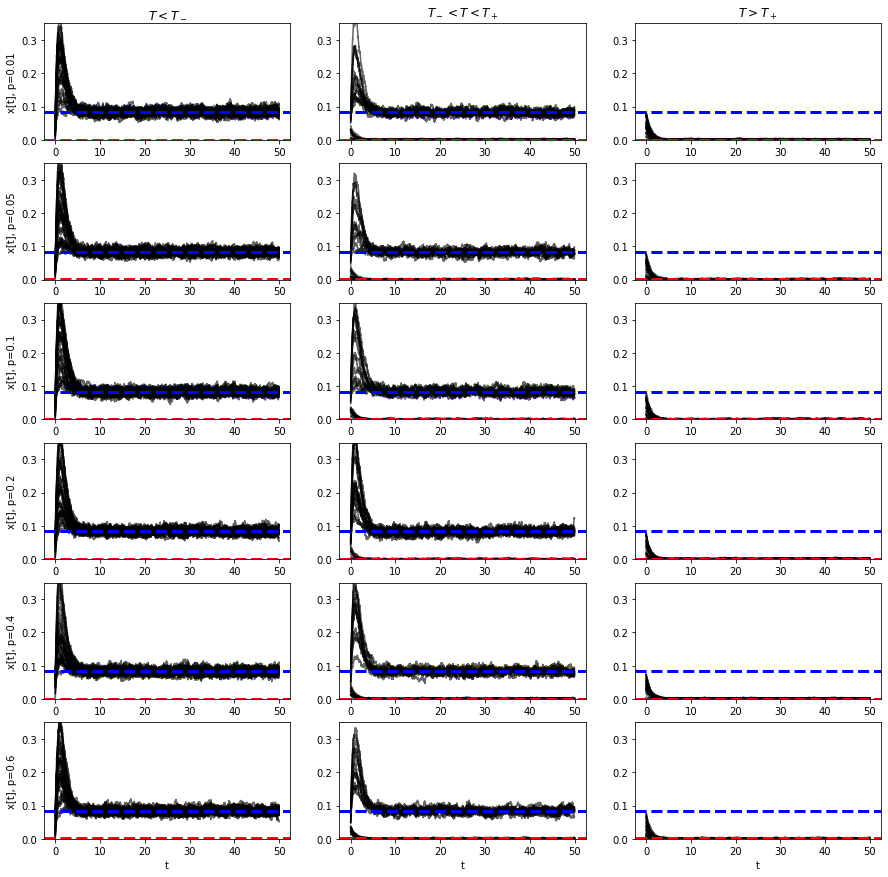

In [265]:
plt.figure(figsize=(15,15))

for i, p in enumerate(ps):
    for j, T in enumerate(Ts):
        plt.subplot(len(ps),len(Ts),i*len(Ts)+j+1)
        
        for traj in res[i][j]:
            plt.plot(np.arange(steps)*dt, traj, c='k', alpha=0.6)
        plt.axhline(xplus, ls='--', c='blue', label=r'$x_+$', lw=3)
        plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
        plt.ylim([0,.35])
        
        if i==0:
            plt.title(titles[j])
        
        if j%len(Ts)==0:
            plt.ylabel('x[t], p='+str(p))
        if i==len(ps)-1:
            plt.xlabel('t')
plt.show()

In [277]:
ps = [0.05, 0.1, 0.2, 0.4, 0.6]
dt = 0.01
steps = int(5e3)
N = int(1e3)

res_hist = []

for p in ps:    
    # Generate graphs
    print('[*] Generating topology for p={:.1f}'.format(p))
    top = ig.Graph.Erdos_Renyi(n=N, p=p).get_adjacency_sparse().toarray()
    
    # Homeostatic normalization
    top = normalize(top)
    
    tmp = run_htc_hysteresis(top, dt, steps, eq_steps=int(5e3), N=N, r1=r1, r2=r2, Tmin=xminus/5, Tmax=5*Tplus, Tdiv_log=True, nT=60, runs=1, display=True)
    name = 'hist_N_{}_dt_{}_p_{}.npy'.format(N,np.round(dt,3),np.round(p,2),np.round(np.log10(T),2))
    np.save(folder+name, tmp)
    res_hist.append(tmp)

End simulating activity
Total computation time: 309.97s


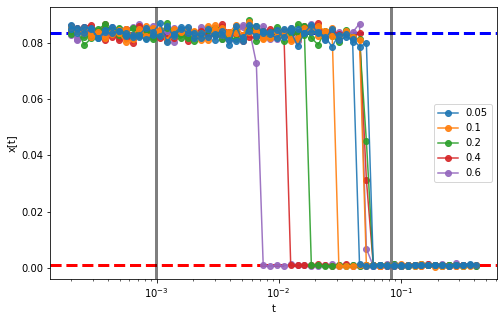

In [278]:
plt.figure(figsize=(8,5))

for i, res in enumerate(res_hist):
    plt.plot(res[0], res[1], '-o', zorder=50-i, label=ps[i], alpha=0.9)

plt.xscale('log')
plt.xlabel('t')
plt.ylabel('x[t]')

plt.axhline(xplus, ls='--', c='blue', lw=3, zorder=1)
plt.axhline(xminus, ls='--', c='r', lw=3, zorder=1)

plt.axvline(xplus, lw=3, zorder=1, c='k', alpha=0.5)
plt.axvline(xminus, lw=3, zorder=1, c='k', alpha=0.5)

plt.legend()
plt.show()

In [281]:
ps = [0.1]
ks = np.arange(0,1+0.1,0.1)
#Ts = [Tminus + 0.5*(Tplus-Tminus)]
Ts = Tminus + ks*(Tplus-Tminus)
#Ts = [0.5*Tminus, Tminus + 0.3*(Tplus-Tminus), Tminus + 0.5*(Tplus-Tminus), Tminus + 0.7*(Tplus-Tminus), 2.*Tplus]
titles = [r'$T<T_-$', r'$T_-<T<T_+$', r'$T>T_+$']

dt = 0.01
steps = int(5e4)
N = int(1e3)

res_1 = []

for p in ps:
    tmp_res = []
    
    # Generate graphs
    print('[*] Generating topology for p={:.1f}'.format(p))
    top = ig.Graph.Erdos_Renyi(n=N, p=p).get_adjacency_sparse().toarray()
    
    # Homeostatic normalization
    top = normalize(top)
    
    for T in Ts:
        print('[-] T='+str(T))
        # Run model
        x, y = run_htc_single(None, xplus, yplus, T, r1, r2, dt, steps, N=N, runs=30)
        tmp_res.append(x)
        
        name = 'traj_N_{}_dt_{}_p_{}_T_{}.npy'.format(N,np.round(dt,3),np.round(p,2),np.round(np.log10(T),2))
        np.save(folder+name, x)
    
    res_1.append(tmp_res)

[*] Generating topology for p=0.1
[-] T=0.0009891196834817012
[-] T=0.009223541048466866
[-] T=0.01745796241345203
[-] T=0.0256923837784372
[-] T=0.033926805143422355
[-] T=0.04216122650840752
[-] T=0.05039564787339269
[-] T=0.05863006923837785
[-] T=0.06686449060336301
[-] T=0.07509891196834818
[-] T=0.08333333333333334


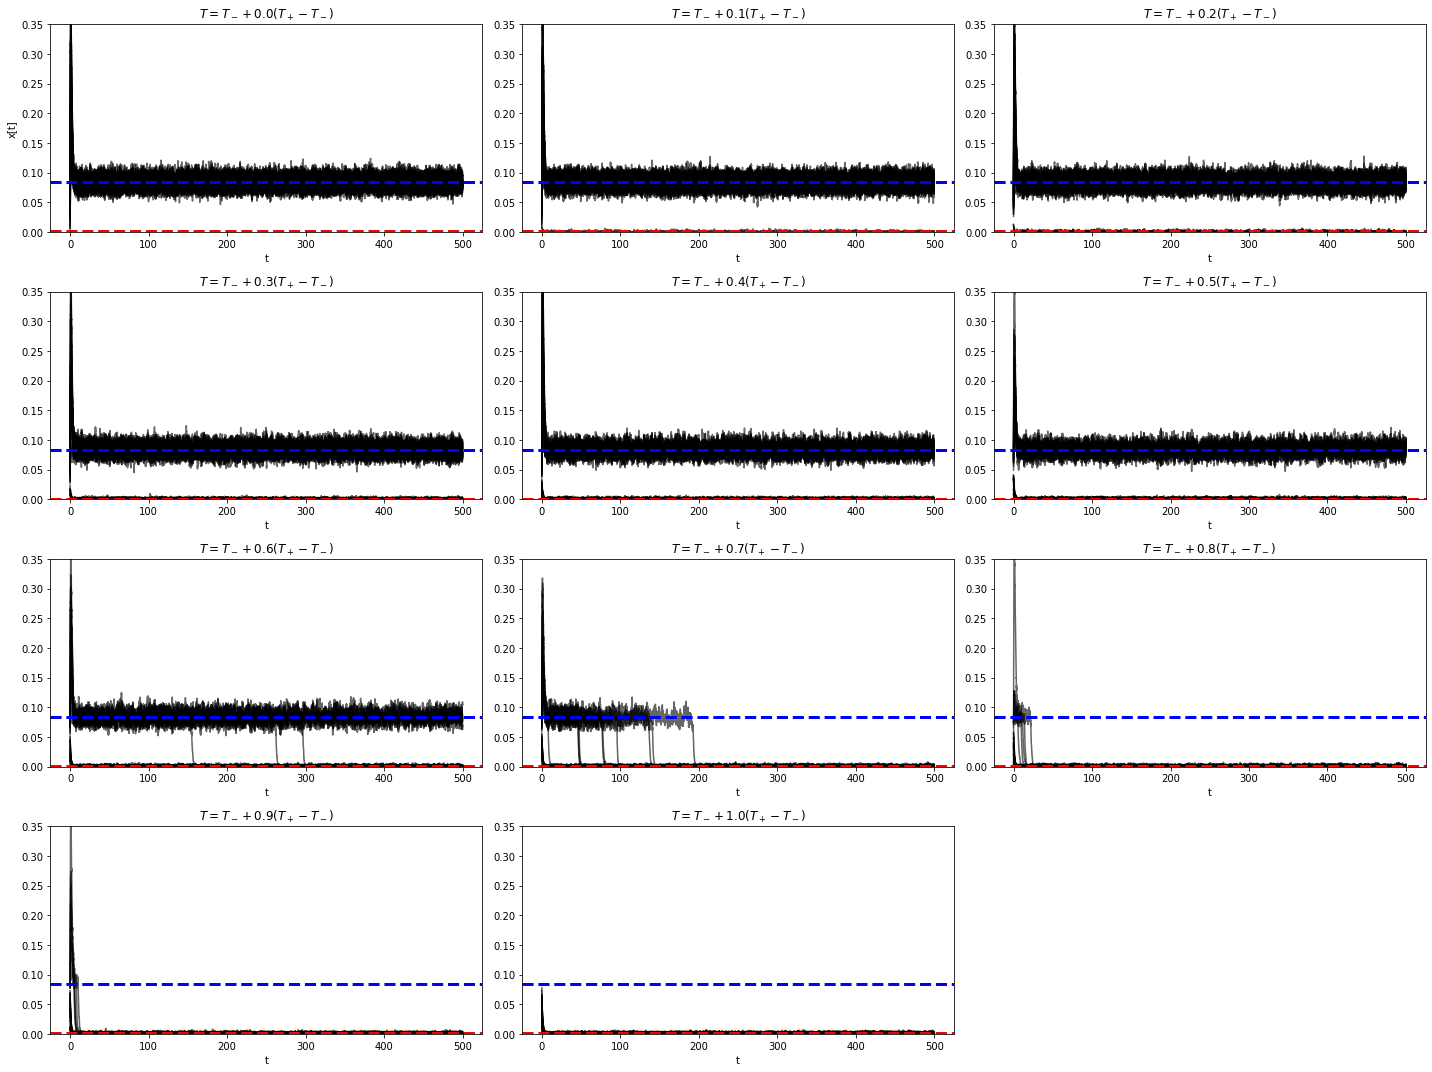

In [282]:
plt.figure(figsize=(20,15))

for j, T in enumerate(Ts):
    plt.subplot(4,len(Ts)//3,j+1)
        
    for traj in res_1[0][j]:
        plt.plot(np.arange(steps)*dt, traj, c='k', alpha=0.6)
    plt.axhline(xplus, ls='--', c='blue', label=r'$x_+$', lw=3)
    plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
    plt.ylim([0,.35])
        
    if j==0:
        plt.ylabel('x[t]')
    plt.xlabel('t')
    plt.title(r'$T=T_- + $'+str(np.round(ks[j],1))+r'$(T_+ - T_-)$')

plt.tight_layout()
plt.show()

# Change weights distributions
* uniform
* power law/exponential (see other works)
* truncated normal
* power law

In [305]:
def rnd_powlaw(a, b, g, size):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    
    return (ag + (bg - ag)*r)**(1./g)

def generate_random(pdf, N, lmbd=None):
    if pdf == 'uniform':
        mat = np.random.uniform(size=(N,N))
    elif pdf == 'exp':
        if lmbd is None:
            lmbd = 12.5
        mat = np.random.exponential(scale=1/lmbd, size=(N,N))
    elif pdf == 'normal':
        mat = truncnorm.rvs(0, 1, size=(N,N))
    elif pdf == 'powlaw':
        if lmbd is None:
            lmbd = -0.5
        mat = rnd_powlaw(1e-5, 1, lmbd, size=(N,N))
    
    # Symmetrize
    mat = np.triu(mat, k=1)
    mat += mat.T
    
    return mat

In [317]:
pdfs = ['uniform', 'exp', 'normal', 'powlaw']
#pdfs = ['uniform']

dt = 0.01
steps = int(5e3)
eq_steps = int(5e3)
N = int(1e3)

res_2 = []

for pdf in pdfs:
    
    # Generate graphs
    print('[*] Generating topology for pdf:'+pdf)
    top = generate_random(pdf, N)
    # Homeostatic normalization
    top = normalize(top)
    
    # Run model
    tmp = run_htc_hysteresis(top, dt, steps, eq_steps=eq_steps, N=N, r1=r1, r2=r2, Tmin=xminus/5, Tmax=5*Tplus, Tdiv_log=True, nT=60, runs=1, display=True)
    res_2.append(tmp)
    
    name = 'hist_N_{}_dt_{}_pdf_{}.npy'.format(N,np.round(dt,3),pdf)
    np.save(folder+name, tmp)


29/119 - T = 0.09 * T+
Simulating activity...
Running equilibration...


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8,5))

for i, res in enumerate(res_2):
    plt.plot(res[0], res[1], '-o', zorder=2, label=pdfs[i], alpha=0.7)

plt.xscale('log')
plt.xlabel('t')
plt.ylabel('x[t]')

plt.axhline(xplus, ls='--', c='blue', lw=3, zorder=1)
plt.axhline(xminus, ls='--', c='r', lw=3, zorder=1)

plt.axvline(xplus, lw=3, zorder=1, c='k', alpha=0.5)
plt.axvline(xminus, lw=3, zorder=1, c='k', alpha=0.5)

plt.legend()
plt.show()

In [319]:
pdfs = ['uniform', 'exp', 'normal', 'powlaw']
Ts = [0.5*Tminus, Tminus + 0.5*(Tplus-Tminus), 2.*Tplus]
titles = [r'$T<T_-$', r'$T_-<T<T_+$', r'$T>T_+$']

dt = 0.01
steps = int(5e3)
N = int(1e3)

res_3 = []

for pdf in pdfs:
    tmp_res = []
    
    # Generate graphs
    print('[*] Generating topology for pdf='+ pdf)
    top = generate_random(pdf, N)
    # Homeostatic normalization
    top = normalize(top)
    
    for T in Ts:
        print('[-] T='+str(T))
        # Run model
        x, y = run_htc_single(top, xplus, yplus, T, r1, r2, dt, steps, N=N, runs=30)
        tmp_res.append(x)
        
        name = 'traj_N_{}_dt_{}_pdf_{}_T_{}.npy'.format(N,np.round(dt,3),pdf,np.round(np.log10(T),2))
        np.save(folder+name, x)
    res_3.append(tmp_res)

[*] Generating topology for pdf=uniform
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for pdf=exp
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for pdf=normal
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for pdf=powlaw
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669


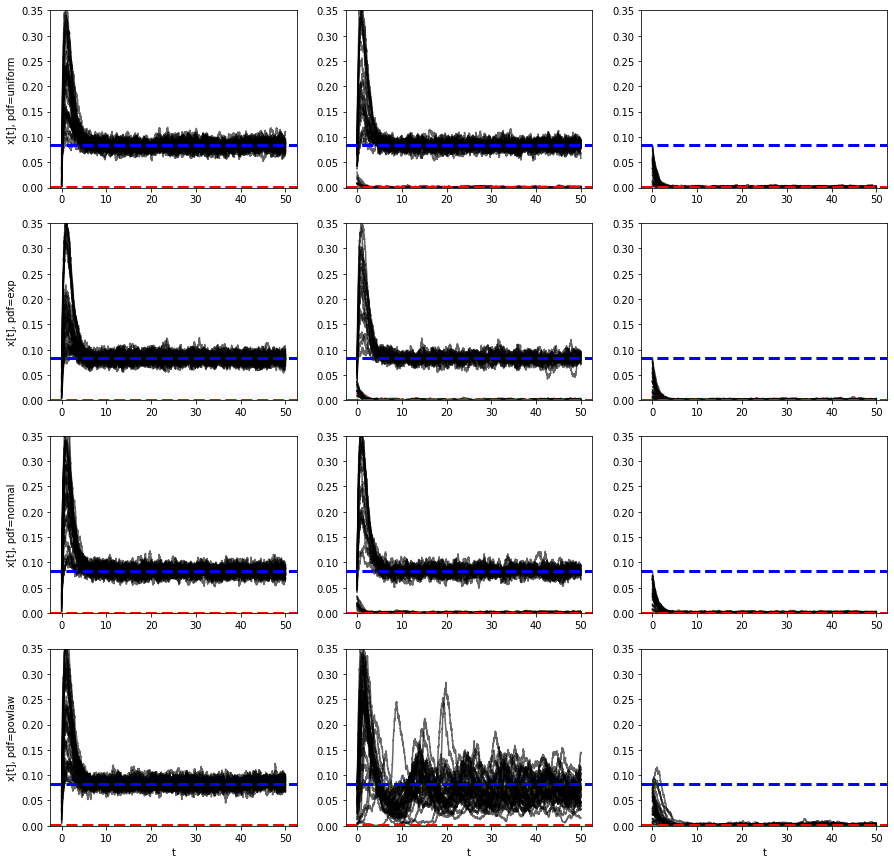

In [320]:
plt.figure(figsize=(15,15))

for i, pdf in enumerate(pdfs):
    for j, T in enumerate(Ts):
        plt.subplot(len(pdfs),len(Ts),i*len(Ts)+j+1)
        
        for traj in res_3[i][j]:
            plt.plot(np.arange(steps)*dt, traj, c='k', alpha=0.6)
        plt.axhline(xplus, ls='--', c='blue', label=r'$x_+$', lw=3)
        plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
        plt.ylim([0,.35])
        
        if j%len(Ts)==0:
            plt.ylabel('x[t], pdf='+str(pdfs[i]))
        if i==len(pdfs)-1:
            plt.xlabel('t')
plt.show()

# Change connectivity + weights

In [26]:
pdfs = ['uniform', 'exp', 'normal']
ps = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8]

Ts = [0.5*Tminus, Tminus + 0.5*(Tplus-Tminus), 2.*Tplus]
titles = [r'$T<T_-$', r'$T_-<T<T_+$', r'$T>T_+$']

dt = 0.05
steps = int(1e3)
N = int(1e3)

res_3 = []

for pdf in pdfs:
    tmp_res_1 = []
    
    for p in ps:
        tmp_res_2 = []
        
        # Generate weights
        print('[*] Generating topology for pdf='+ pdf)
        weights = generate_random(pdf, N)
        
        # Generate graphs
        print('[*] Generating topology for p='+ str(p))
        top = ig.Graph.Erdos_Renyi(n=N, p=p).get_adjacency_sparse().toarray()
        
        # Mask weights with network
        top = weights * top
        
        # Homeostatic normalization
        top = normalize(top)
    
        for T in Ts:
            print('[-] T='+str(T))
            # Run model
            x, y = run_htc_single(top, xplus, yplus, T, r1, r2, dt, steps, N=N, runs=30)
            tmp_res_2.append(x)
        tmp_res_1.append(tmp_res_2)
    res_3.append(tmp_res_1)

[*] Generating topology for p=0.1
[*] Generating topology for pdf=uniform
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.2
[*] Generating topology for pdf=uniform
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.3
[*] Generating topology for pdf=uniform
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.4
[*] Generating topology for pdf=uniform
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.6
[*] Generating topology for pdf=uniform
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.8
[*] Generating topology for pdf=uniform
[-] T=0.0004945598417408506
[-] T=0.04216122650840752
[-] T=0.16666666666666669
[*] Generating topology for p=0.1
[*] Generating topology for pdf=exp
[-] T=

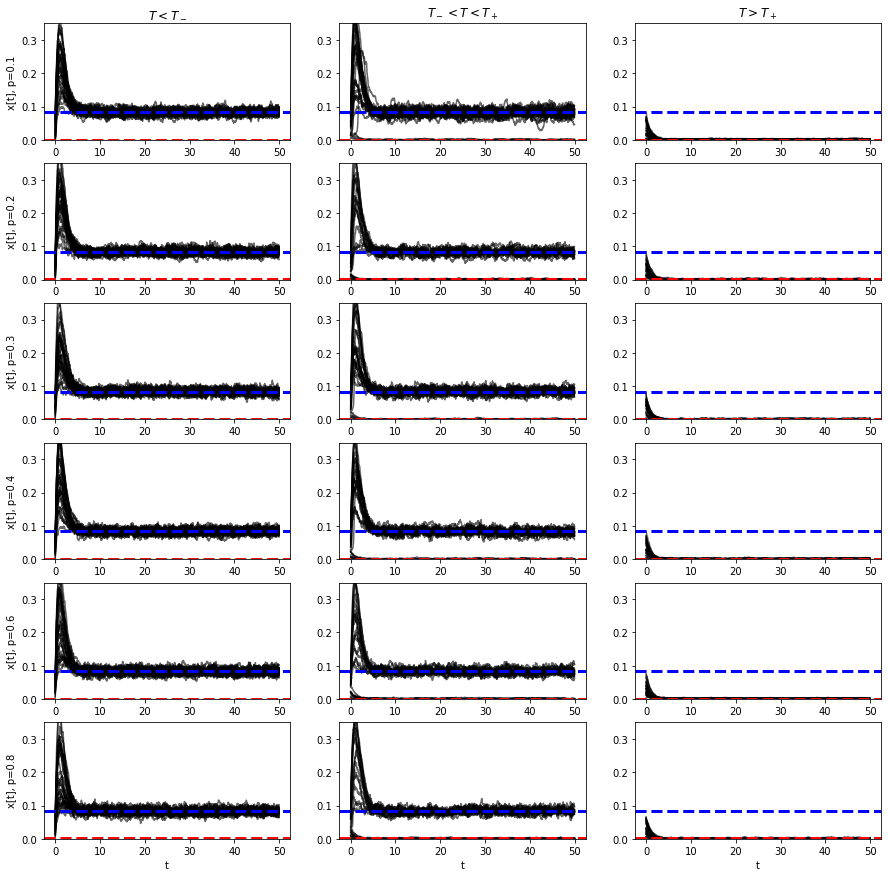

In [27]:
plt.figure(figsize=(15,15))

for i, p in enumerate(ps):
    for j, T in enumerate(Ts):
        plt.subplot(len(ps),len(Ts),i*len(Ts)+j+1)
        
        for traj in res_3[0][i][j]:
            plt.plot(np.arange(steps)*dt, traj, c='k', alpha=0.6)
        plt.axhline(xplus, ls='--', c='blue', label=r'$x_+$', lw=3)
        plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
        plt.ylim([0,.35])
        
        if i==0:
            plt.title(titles[j])
        
        if j%len(Ts)==0:
            plt.ylabel('x[t], p='+str(p))
        if i==len(ps)-1:
            plt.xlabel('t')
plt.show()

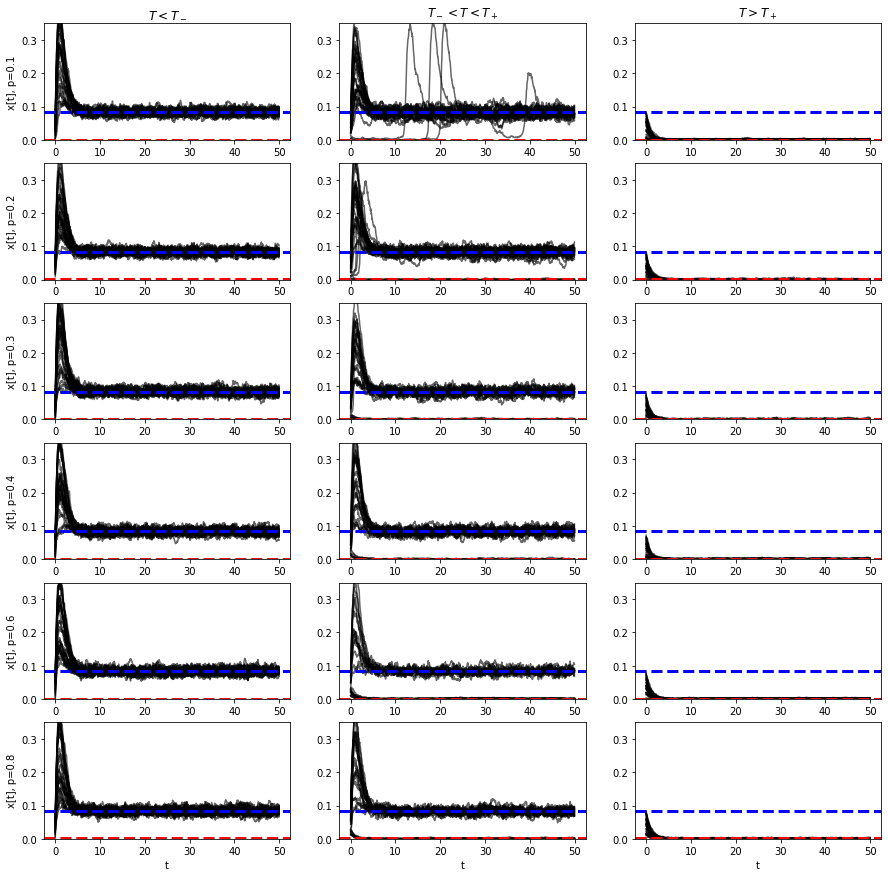

In [28]:
plt.figure(figsize=(15,15))

for i, p in enumerate(ps):
    for j, T in enumerate(Ts):
        plt.subplot(len(ps),len(Ts),i*len(Ts)+j+1)
        
        for traj in res_3[1][i][j]:
            plt.plot(np.arange(steps)*dt, traj, c='k', alpha=0.6)
        plt.axhline(xplus, ls='--', c='blue', label=r'$x_+$', lw=3)
        plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
        plt.ylim([0,.35])
        
        if i==0:
            plt.title(titles[j])
        
        if j%len(Ts)==0:
            plt.ylabel('x[t], p='+str(p))
        if i==len(ps)-1:
            plt.xlabel('t')
plt.show()

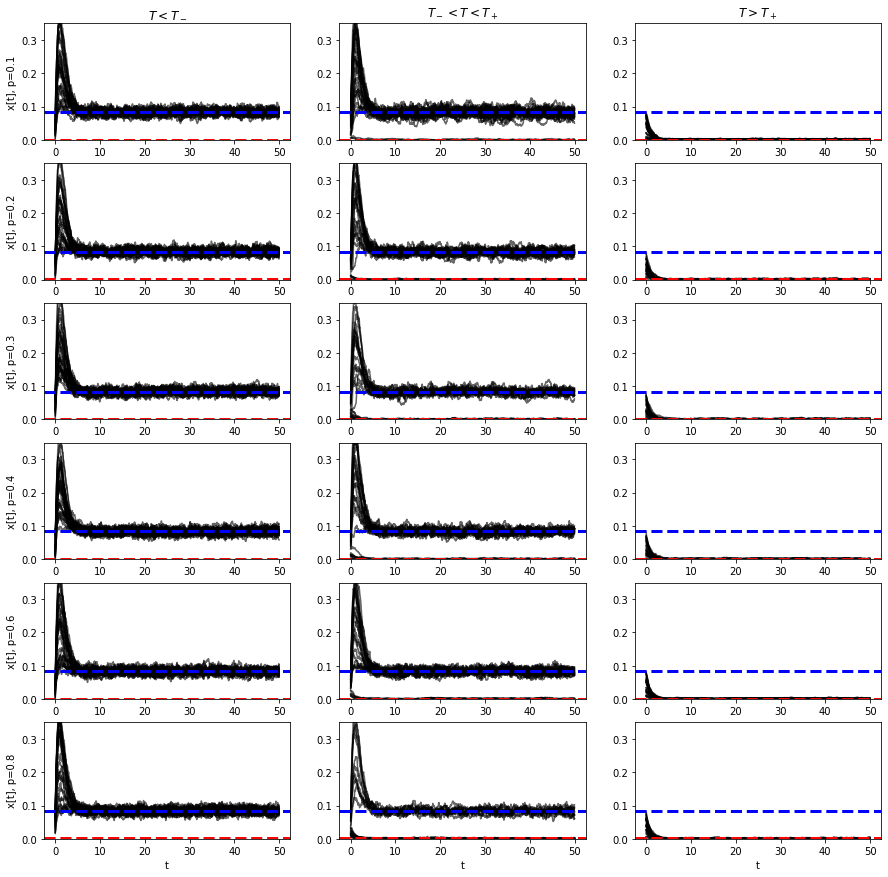

In [29]:
plt.figure(figsize=(15,15))

for i, p in enumerate(ps):
    for j, T in enumerate(Ts):
        plt.subplot(len(ps),len(Ts),i*len(Ts)+j+1)
        
        for traj in res_3[2][i][j]:
            plt.plot(np.arange(steps)*dt, traj, c='k', alpha=0.6)
        plt.axhline(xplus, ls='--', c='blue', label=r'$x_+$', lw=3)
        plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
        plt.ylim([0,.35])
        
        if i==0:
            plt.title(titles[j])
        
        if j%len(Ts)==0:
            plt.ylabel('x[t], p='+str(p))
        if i==len(ps)-1:
            plt.xlabel('t')
plt.show()

In [133]:
pdfs = ['uniform', 'exp', 'normal']
ps = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8]

Ts = [0.5*Tminus, Tminus + 0.5*(Tplus-Tminus), 2.*Tplus]
titles = [r'$T<T_-$', r'$T_-<T<T_+$', r'$T>T_+$']

dt = 0.05
steps = int(1e3)
N = int(1e3)

res_3 = []

for pdf in pdfs:
    tmp_res_1 = []
    
    for p in ps:        
        # Generate weights
        print('[*] Generating topology for pdf='+ pdf)
        weights = generate_random(pdf, N)
        
        # Generate graphs
        print('[*] Generating topology for p='+ str(p))
        top = ig.Graph.Erdos_Renyi(n=N, p=p).get_adjacency_sparse().toarray()
        
        # Mask weights with network
        top = weights * top
        
        # Homeostatic normalization
        top = normalize(top)
        
        tmp = run_htc_hysteresis(top, dt, steps, N=N, r1=r1, r2=r2, Tmin=xminus/5, Tmax=5*Tplus, Tdiv_log=True, nT=40, runs=1, display=True)
    
        tmp_res_1.append(tmp)
    res_3.append(tmp_res_1)

End simulating activity
Total computation time: 48.75s


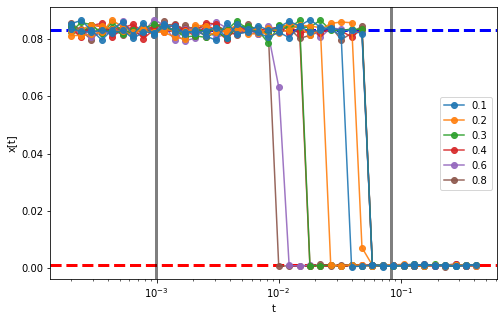

In [134]:
plt.figure(figsize=(8,5))

for i, res in enumerate(res_3[0]):
    plt.plot(res[0], res[1], '-o', zorder=50-i, label=ps[i], alpha=0.9)

plt.xscale('log')
plt.xlabel('t')
plt.ylabel('x[t]')

plt.axhline(xplus, ls='--', c='blue', lw=3, zorder=1)
plt.axhline(xminus, ls='--', c='r', lw=3, zorder=1)

plt.axvline(xplus, lw=3, zorder=1, c='k', alpha=0.5)
plt.axvline(xminus, lw=3, zorder=1, c='k', alpha=0.5)

plt.legend()
plt.show()

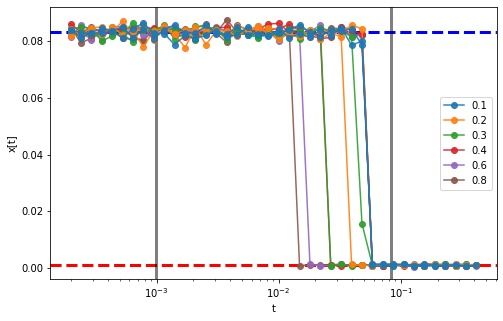

In [135]:
plt.figure(figsize=(8,5))

for i, res in enumerate(res_3[1]):
    plt.plot(res[0], res[1], '-o', zorder=50-i, label=ps[i], alpha=0.9)

plt.xscale('log')
plt.xlabel('t')
plt.ylabel('x[t]')

plt.axhline(xplus, ls='--', c='blue', lw=3, zorder=1)
plt.axhline(xminus, ls='--', c='r', lw=3, zorder=1)

plt.axvline(xplus, lw=3, zorder=1, c='k', alpha=0.5)
plt.axvline(xminus, lw=3, zorder=1, c='k', alpha=0.5)

plt.legend()
plt.show()

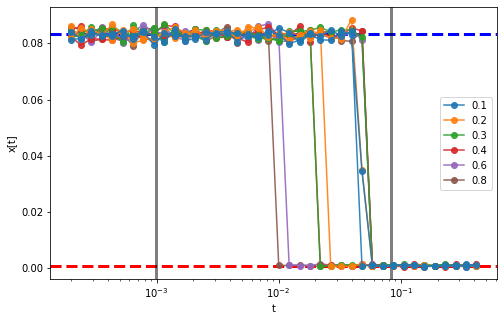

In [136]:
plt.figure(figsize=(8,5))

for i, res in enumerate(res_3[2]):
    plt.plot(res[0], res[1], '-o', zorder=50-i, label=ps[i], alpha=0.9)

plt.xscale('log')
plt.xlabel('t')
plt.ylabel('x[t]')

plt.axhline(xplus, ls='--', c='blue', lw=3, zorder=1)
plt.axhline(xminus, ls='--', c='r', lw=3, zorder=1)

plt.axvline(xplus, lw=3, zorder=1, c='k', alpha=0.5)
plt.axvline(xminus, lw=3, zorder=1, c='k', alpha=0.5)

plt.legend()
plt.show()

# Connectome - Hysteresis + trajectories

## 1) Connectome

In [352]:
dt = 0.01
steps = int(1e4)

res_connectome_1 = []
    
# Run model
tmp = run_htc_hysteresis(W, dt, steps, eq_steps=int(5e3), N=W.shape[0], r1=r1, r2=r2, Tmin=xminus/5, Tmax=5*Tplus, Tdiv_log=True, nT=60, runs=1, display=True)
res_connectome_1.append(tmp)

name = 'kkk_hist_connectome_dt_{}.npy'.format(np.round(dt,3))
np.save(folder+name, tmp)

End simulating activity
Total computation time: 457.05s


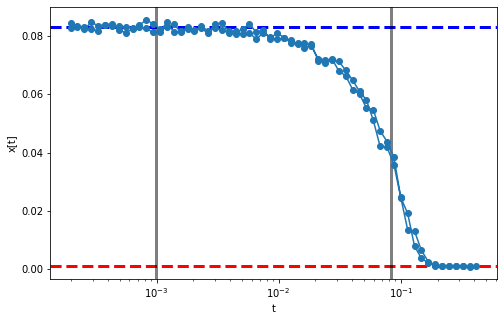

In [353]:
plt.figure(figsize=(8,5))

plt.plot(res_connectome_1[0][0], res_connectome_1[0][1], '-o', zorder=2)

plt.xscale('log')
plt.xlabel('t')
plt.ylabel('x[t]')

plt.axhline(xplus, ls='--', c='blue', lw=3, zorder=1)
plt.axhline(xminus, ls='--', c='r', lw=3, zorder=1)

plt.axvline(xplus, lw=3, zorder=1, c='k', alpha=0.5)
plt.axvline(xminus, lw=3, zorder=1, c='k', alpha=0.5)

#plt.legend()
plt.show()

In [334]:
ks = np.arange(0,1.4,0.1)
Ts = Tminus + ks*(Tplus-Tminus)

dt = 0.01
steps = int(5e3)

res_connectome = []
    
for T in Ts:
    print('[-] T='+str(T))
    # Run model
    x, y = run_htc_single(W, xplus, yplus, T, r1, r2, dt, steps, N=W.shape[0], runs=30)
    res_connectome.append(x)
    
    name = 'traj_connectome_dt_{}_T_{}.npy'.format(np.round(dt,3),np.round(np.log10(T),2))
    np.save(folder+name, x)

[-] T=0.0009891196834817012
[-] T=0.009223541048466866
[-] T=0.01745796241345203
[-] T=0.0256923837784372
[-] T=0.033926805143422355
[-] T=0.04216122650840752
[-] T=0.05039564787339269
[-] T=0.05863006923837785
[-] T=0.06686449060336301
[-] T=0.07509891196834818
[-] T=0.08333333333333334
[-] T=0.09156775469831852
[-] T=0.09980217606330369
[-] T=0.10803659742828883


In [ ]:
### plt.figure(figsize=(20,15))

for j, T in enumerate(Ts):
    plt.subplot(4,len(Ts)//3,j+1)
        
    for traj in res_connectome[j]:
        plt.plot(np.arange(steps)*dt, traj, c='k', alpha=0.6)
    plt.axhline(xplus, ls='--', c='blue', label=r'$x_+$', lw=3)
    plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
    plt.ylim([0,.35])
        
    if j==0:
        plt.ylabel('x[t]')
    plt.xlabel('t')
    plt.title(r'$T=T_- + $'+str(np.round(ks[j],1))+r'$(T_+ - T_-)$')

plt.tight_layout()
plt.show()

## 2) Randomized connectome

In [339]:
dt = 0.01
steps = int(5e3)
    
# Run model
res_connectome_rand = run_htc_hysteresis(Wrand, dt, steps, eq_steps=int(5e3), N=W.shape[0], r1=r1, r2=r2, Tmin=xminus/5, Tmax=5*Tplus, Tdiv_log=True, nT=60, runs=1, display=True)

name = 'hist_connectome_rand_dt_{}.npy'.format(np.round(dt,3))
np.save(folder+name, res_connectome_rand)

End simulating activity
Total computation time: 277.85s


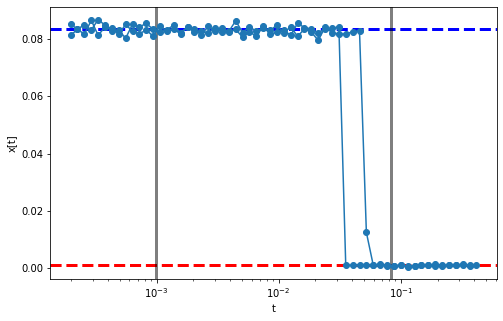

In [340]:
plt.figure(figsize=(8,5))

plt.plot(res_connectome_rand[0], res_connectome_rand[1], '-o', zorder=2)

plt.xscale('log')
plt.xlabel('t')
plt.ylabel('x[t]')

plt.axhline(xplus, ls='--', c='blue', lw=3, zorder=1)
plt.axhline(xminus, ls='--', c='r', lw=3, zorder=1)

plt.axvline(xplus, lw=3, zorder=1, c='k', alpha=0.5)
plt.axvline(xminus, lw=3, zorder=1, c='k', alpha=0.5)

#plt.legend()
plt.show()

In [176]:
ks = np.arange(0,1.4,0.1)
Ts = Tminus + ks*(Tplus-Tminus)

dt = 0.05
steps = int(1e3)
N = int(1e3)

res_connectome_rand_traj = []
    
for T in Ts:
    print('[-] T='+str(T))
    # Run model
    x, y = run_htc_single(Wrand, xplus, yplus, T, r1, r2, dt, steps, N=W.shape[0], runs=30)
    res_connectome_rand_traj.append(x)

[-] T=0.0009891196834817012
[-] T=0.009223541048466866
[-] T=0.01745796241345203
[-] T=0.0256923837784372
[-] T=0.033926805143422355
[-] T=0.04216122650840752
[-] T=0.05039564787339269
[-] T=0.05863006923837785
[-] T=0.06686449060336301
[-] T=0.07509891196834818
[-] T=0.08333333333333334
[-] T=0.09156775469831852
[-] T=0.09980217606330369
[-] T=0.10803659742828883


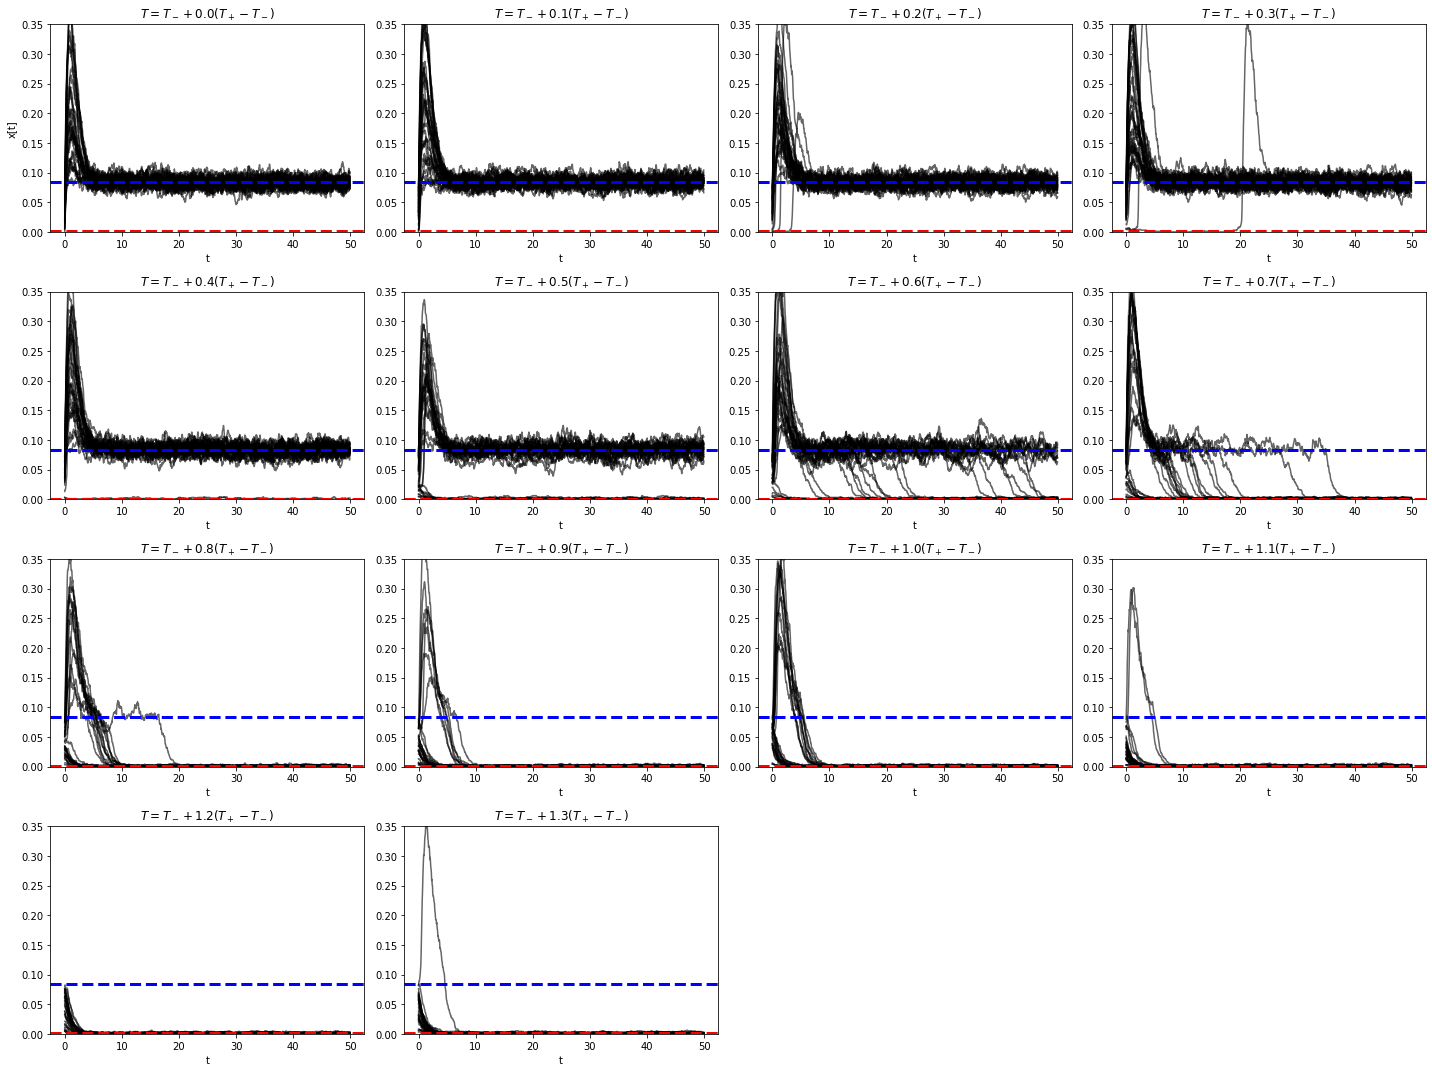

In [177]:
plt.figure(figsize=(20,15))

for j, T in enumerate(Ts):
    plt.subplot(4,len(Ts)//3,j+1)
        
    for traj in res_connectome_rand_traj[j]:
        plt.plot(np.arange(steps)*dt, traj, c='k', alpha=0.6)
    plt.axhline(xplus, ls='--', c='blue', label=r'$x_+$', lw=3)
    plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
    plt.ylim([0,.35])
        
    if j==0:
        plt.ylabel('x[t]')
    plt.xlabel('t')
    plt.title(r'$T=T_- + $'+str(np.round(ks[j],1))+r'$(T_+ - T_-)$')

plt.tight_layout()
plt.show()

## 3) Binarized connectome

In [347]:
dt = 0.01
steps = int(1e3)
    
# Run model
res_connectome_bin = run_htc_hysteresis(Wbin, dt, steps, eq_steps=int(1e3), N=W.shape[0], r1=r1, r2=r2, Tmin=xminus/5, Tmax=5*Tplus, Tdiv_log=True, nT=60, runs=1, display=True)

#name = 'hist_connectome_bin_dt_{}.npy'.format(np.round(dt,3))
#np.save(folder+name, res_connectome_bin)


End simulating activity
Total computation time: 75.57s


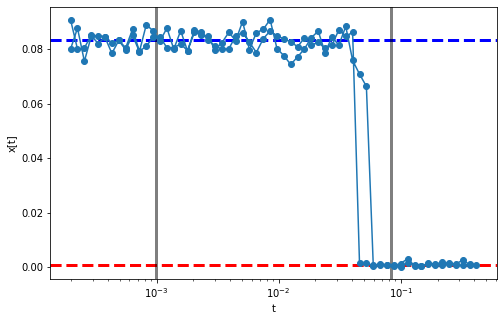

In [348]:
plt.figure(figsize=(8,5))

plt.plot(res_connectome_bin[0], res_connectome_bin[1], '-o', zorder=2)

plt.xscale('log')
plt.xlabel('t')
plt.ylabel('x[t]')

plt.axhline(xplus, ls='--', c='blue', lw=3, zorder=1)
plt.axhline(xminus, ls='--', c='r', lw=3, zorder=1)

plt.axvline(xplus, lw=3, zorder=1, c='k', alpha=0.5)
plt.axvline(xminus, lw=3, zorder=1, c='k', alpha=0.5)

#plt.legend()
plt.show()

In [192]:
ks = np.arange(0,1.4,0.1)
Ts = Tminus + ks*(Tplus-Tminus)

dt = 0.05
steps = int(1e3)
N = int(1e3)

res_connectome_bin = []
    
for T in Ts:
    print('[-] T='+str(T))
    # Run model
    x, y = run_htc_single(Wbin, xplus, yplus, T, r1, r2, dt, steps, N=W.shape[0], runs=30)
    res_connectome_bin.append(x)

[-] T=0.0009891196834817012
[-] T=0.009223541048466866
[-] T=0.01745796241345203
[-] T=0.0256923837784372
[-] T=0.033926805143422355
[-] T=0.04216122650840752
[-] T=0.05039564787339269
[-] T=0.05863006923837785
[-] T=0.06686449060336301
[-] T=0.07509891196834818
[-] T=0.08333333333333334
[-] T=0.09156775469831852
[-] T=0.09980217606330369
[-] T=0.10803659742828883


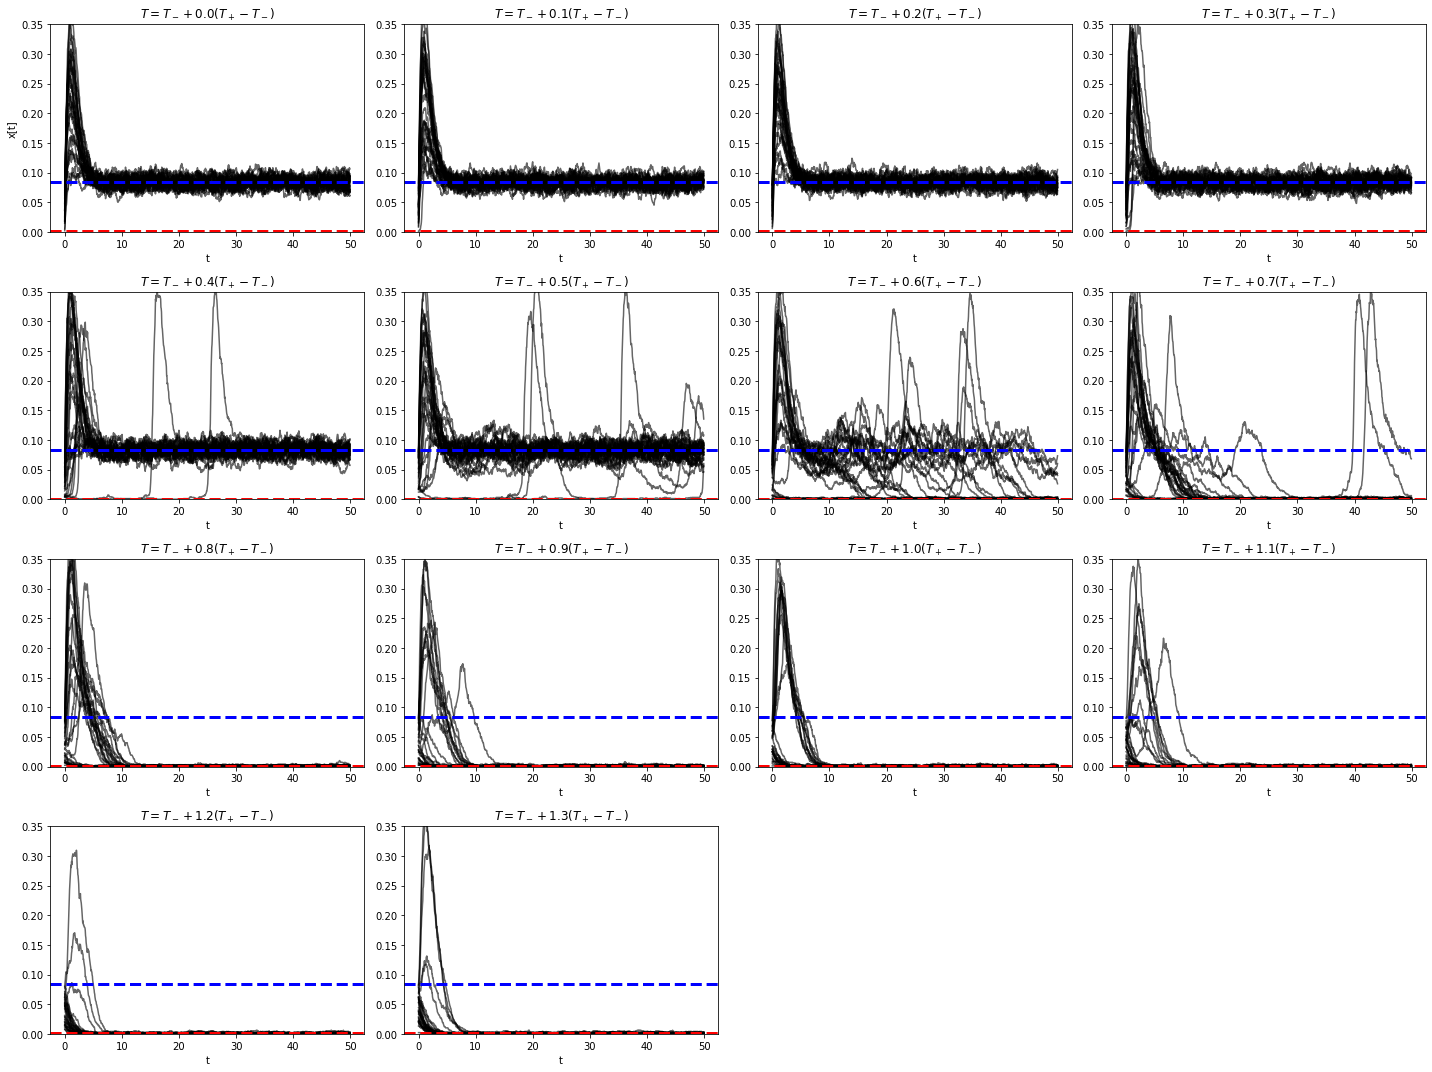

In [193]:
plt.figure(figsize=(20,15))

for j, T in enumerate(Ts):
    plt.subplot(4,len(Ts)//3,j+1)
        
    for traj in res_connectome_bin[j]:
        plt.plot(np.arange(steps)*dt, traj, c='k', alpha=0.6)
    plt.axhline(xplus, ls='--', c='blue', label=r'$x_+$', lw=3)
    plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
    plt.ylim([0,.35])
        
    if j==0:
        plt.ylabel('x[t]')
    plt.xlabel('t')
    plt.title(r'$T=T_- + $'+str(np.round(ks[j],1))+r'$(T_+ - T_-)$')

plt.tight_layout()
plt.show()

# Power spectrum (long trajectories)

In [5]:
dT = 0.15
Ts = np.arange(0, 3, dT) * Tplus

dt = 0.05
steps = int(1e6)
runs = 10

In [ ]:
for T in Ts:
    print('[-] T='+str(T))
    # Run model
    x, y = run_htc_single(W, xplus, yplus, T, r1, r2, dt, steps, eq_steps=int(1e3), N=W.shape[0], runs=runs)
    
    name = 'traj_long_connectome_dt_{}_steps_{}_T_{}.npy'.format(np.round(dt,3),steps,np.round(np.log10(T),2))
    np.save(folder+name, x)

[-] T=0.0


In [ ]:
for T in Ts:
    print('[-] T='+str(T))
    # Run model
    x, y = run_htc_single(Wbin, xplus, yplus, T, r1, r2, dt, steps, eq_steps=int(1e3), N=W.shape[0], runs=runs)
    
    name = 'traj_long_connectome_bin_dt_{}_steps_{}_T_{}.npy'.format(np.round(dt,3),steps,np.round(np.log10(T),2))
    np.save(folder+name, x)

In [ ]:
for T in Ts:
    print('[-] T='+str(T))
    # Run model
    x, y = run_htc_single(Wrand, xplus, yplus, T, r1, r2, dt, steps, eq_steps=int(1e3), N=W.shape[0], runs=runs)
    
    name = 'traj_long_connectome_rand_dt_{}_T_{}.npy'.format(np.round(dt,3),np.round(np.log10(T),2))
    np.save(folder+name, x)

# Dynamic range

In [25]:
Nstim = 50
stimuli = np.logspace(-5, 0, Nstim, endpoint=True)

nT = 60
Trange = np.logspace(np.log10(xminus/5), np.log10(5*Tplus), nT, endpoint=True)

In [ ]:
dt = 0.01
steps = int(5e3)

stimulated = np.zeros((nT,Nstim))

for i in range(nT):
    for j, stimulus in enumerate(stimuli):
        x, y = run_htc_single(W, xplus, yplus, Trange[i], stimuli[j], r2, dt, steps, eq_steps=int(1e3), N=W.shape[0], runs=10)
        stimulated[i,j] = np.mean(x)